# Simulation of a semi-resolved dwarf galaxy

The purpose of this notebook is to sketch out the steps in simulating a semi-resolved dwarf galaxy. The steps are as follows:

 1. Select an isochrone
     - which gives the colors and luminosities of stars as a function of mass for a particular fixed age and metallicity
     - ideally someone has already done the work to compute the colors for the telescope and filter of interest
     - There are some nifty isochrones at http://waps.cfa.harvard.edu/MIST/
 1. Select a total mass for the dwarf galaxy
     - ultimately, at random from a galaxy stellar-mass function (Schechter)
 1. Draw star masses at random from an initial mass function 
     - There is a package for this https://github.com/keflavich/imf. One could also do this with Astropy models no doubt, but that would require more thought.
     - need to decide on a lower mass limit for this so we don't spend all our time on stars that don't contribute to fluctuations. Add those in as one additional smooth component, with the right total flux relative to the stars we have added individually.
         - simplest shortcut to this is probably to include stars only above the Main-sequence turnoff (in phase >0) in the stochastic component. But for younger populations, we might need to keep Main-sequence stars, so let's make this 1 solar mass or the MSTO, whichever is smaller.  
     - draw enough stars that the total mass of the smooth + individual components adds up to the total mass you want for the dwarf galaxy.
     - $N_{indiv}$ is the total number of individual stars
 1. Create a star catalog by assigning the colors and luminosities to the stars according to the isochrone
 1. Choose a distance (or equivalently distance modulus $DM = -5 * log10(distance Mpc) + 25$
 1. Convert luminosities to apparent magnitudes using this distance
 1. Choose a 2D model profile for the galaxy
     - Typically, these galaxies have Sersic profiles with n ~ 1, half-light radii of ~ 0.5-1 kpc and axial ratios between 0.5 and 1
     - We will ultimately want to draw these from distribution functions (there are some in the literature)
     - This should be oversampled by at least a factor of 4 relative to the pixel sampling of the telescope/survey of choice (e.g. WFIRST, LSST or HSC).  
 1. Make an image from the profile where the value in each pixel is the stellar mass, and the total sums to the desired stellar mass
 1. For each pixel draw the right number of stars at random from the isochrone
     - The mass in the pixel $M_{pix}$ is given from the smooth image we just made
     - The number of stars $N_{pix}$ to draw for this pixel is then $N_{indiv} * M_{pix}/M_{tot}$
     - Draw $N_{pix}$ stars at random from the star catalog and increment the flux in this (over-resolved) pixel by this amount
 1. Add in the flux for the smooth component (which is just the model profile scaled by the mass fraction and multipled by a normalization to get it from mass to luminosity)
 1. Convolve this image with an oversampled PSF from the survey of choice 
 1. Resample to the pixelization of the survey
 1. Either add to a real survey image or add sky background and artificial noise
    - Quick & dirty is to ignore Poisson noise from the stars and either just add the noiseless image to the survey data, or measure the RMS in blank sky in the survey and use that to set the rms and mean level for the sky background
    - Ultimately there are correlations introduced by dithering that we probably need to take into account or simulate
    - There is also Poisson noise (photon counting statistics) for the galaxy we just simulated but that's sub-dominant relative to sky: the central surface brightnesses of these galaxies are typically well below the mean sky level.
 

In [54]:
import imf # https://github.com/keflavich/imf
from astropy.table import Table
from scipy import interpolate
import numpy as np
from astropy import modeling

In [55]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

Get the WFIRST PSF....skip this this for other telescopes

In [61]:
import os
os.environ['WEBBPSF_PATH']='/Users/hcferguson/data/wfirst_hackday/'
os.environ['PYSYN_CDBS']='/Users/hcferguson/data/pysynphot/grp/hst/cdbs'
import webbpsf
from webbpsf import wfirst

In [62]:
ZPT=27 # Arbitrary zeropoint for making linear fluxes ...might even be the right zeropoint for HSC
DM=30
isochrone=Table.read('MIST_v1.2_vvcrit0.4_WFIRST/MIST_v1.2_feh_m0.50_afe_p0.0_vvcrit0.4_WFIRST_logage1.03.iso.cmd',
                     format='ascii.commented_header')
isochrone['jflux']=10**((isochrone['J129']-ZPT+DM)/-2.5)

So we don't spend all our time drawing stars that are too faint to contribute significant fluctuations, set a minimum stellar mass for the stochastic component that is either 1 solar mass or the main-sequence turnoff, whichever is smaller. In young stellar populations, the main-sequence stars could be bright & rare enough to contribute fluctuations. In older populations it will be dominated by post-MS stars. 

In [63]:
minmass_stochastic = min(1.0,isochrone['initial_mass'][isochrone['phase']<0.1][-1])
minmass_stochastic

0.7496743013993817

In [59]:
cluster = imf.make_cluster(100000,massfunc='kroupa',mmin=minmass_stochastic)
cluster.sum()

Total cluster mass is 100000 (limit was 100000)


100000.41386839672

Compute the fraction of the total mass in the stochastic component (the rest will be in the smooth component)

In [50]:
kroupa = imf.Kroupa()
mmax = 200
stochastic_mass_fraction = (kroupa.m_integrate(minmass_stochastic, mmax)[0] /
                 kroupa.m_integrate(kroupa.mmin, mmax)[0])
stochastic_mass_fraction

0.6081351955205596

For each random stochastic draw of a mass in the cluster, find the nearest mass to it in the isochrone and make an array of these indices into the isochrone array

In [22]:
mass_indices = np.array([(np.abs(isochrone['initial_mass']-m)).argmin() for m in cluster])

Make a smooth model galaxy with a Sersic profile

In [23]:
N=256
x,y = np.meshgrid(np.arange(N),np.arange(N))
mod = modeling.models.Sersic2D(amplitude=5000,r_eff=20,n=1,x_0=N/2,y_0=N/2,ellip=0.5,theta=-1)

In [24]:
img = mod(x,y)
img.max()

26783.469900166623

In [25]:
flux_image = 0*mod(x,y)
for xx,yy in zip(x.flatten(),y.flatten()):
        if mod(xx,yy) > 0.5:
            random_indices = np.random.randint(0,len(mass_indices),size=int(mod(xx,yy)))
            flux_image[xx,yy] = isochrone['jflux'][mass_indices[random_indices]].sum()

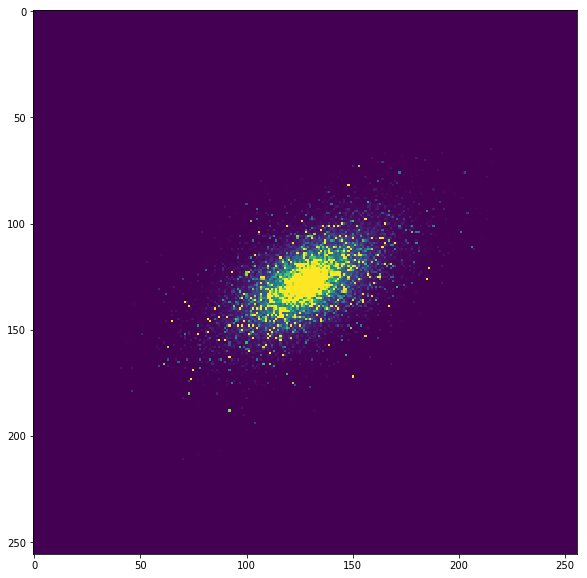

In [26]:
plt.imshow(flux_image,vmax=5)

In [53]:
2.5*np.log10(63095734448.0194)

27.0